In [1]:
import numpy as np
from sklearn.cluster import KMeans

In [24]:
class GMM:
    def __init__(self, n_clusters=10, init_params = 'k-means', max_iter=100):
        self.n_clusters = n_clusters
        self.init_params = init_params
        self.max_iter = max_iter
        
        self.mean = None
        self.covariance = None
        self.gamma = None
        self.pi = None
        
    def k_means_init(self,X):
        kmeans=KMeans(self.n_clusters)
        y=kmeans.fit_predict(X)
        self.mean=kmeans.cluster_centers_
        cluster_index,number_of_points=np.unique(y,return_counts=True)
        number_of_all_points=np.sum(number_of_points)
        self.pi=number_of_points/number_of_all_points
        self.covariance=[]
        for cluster in range(self.n_clusters):
            X_cluster=X[y==cluster]
            self.covariance.append(np.cov(X_cluster.T))
                
    def init_centers(self, X):
        if self.init_params=="k-means":
            self.k_means_init(X)
        
    def pdf(self, x, mean, covariance):
        sigma_inv=np.linalg.inv(covariance)
        sigma_det=np.linalg.det(covariance)
        result=[]
        for point in x:
            result.append(1/np.sqrt(2*np.pi*sigma_det)*np.exp(-1/2*(point-mean)@sigma_inv@(point-mean).T))
        
        return np.array(result)
    
    def fit(self, X):
        self.init_centers(X)
        for _ in range(self.max_iter):
            self.expectation(X)
            self.maximization(X)
    
    def predict(self, X):
        return np.argmax(self.predict_proba(X),axis=1)
        
    def expectation(self, X):
        gamma_numerator=[]
        for k in range(self.n_clusters):
            gamma_cluster_numerator= self.pi[k]*self.pdf(X,self.mean[k],self.covariance[k])
            gamma_numerator.append(gamma_cluster_numerator)
        normalization_factor=np.sum(gamma_numerator,axis=0)
        gamma=gamma_numerator/normalization_factor
        self.gamma=gamma.T
        
    def maximization(self, X):
        N_k=np.sum(self.gamma,axis=0)
        N=np.sum(N_k)
        self.pi = N_k/N
        
        new_mean=[]
        for k in range(self.n_clusters):
            numerator_sum_mean=sum([self.gamma[i,k]*X[i] for i in range(X.shape[0])])
            new_mean.append(1/N_k[k]*numerator_sum_mean)
        self.mean=np.array(new_mean)
        
        new_cov=[]
        for k in range(self.n_clusters):
            numerator_sum_cov=sum([self.gamma[i,k]*np.outer(X[i]-self.mean[k],X[i]-self.mean[k]) for i in range(X.shape[0])])
            new_cov.append(1/N_k[k]*numerator_sum_cov)
            
        self.covariance = new_cov
        
        
    def fit_predict(self, X):
        return self.predict(self.fit(X))
    
    def predict_proba(self, X):
        return self.gamma

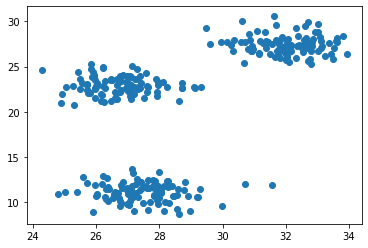

In [25]:
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
x, y_true = make_blobs(n_samples=300, centers=3,
                       cluster_std=1, random_state=2, center_box=(10,50))
plt.scatter(x[:, 0], x[:, 1])

In [26]:
gmm=GMM(3)
gmm.fit(x)

In [28]:
y=gmm.predict(x)

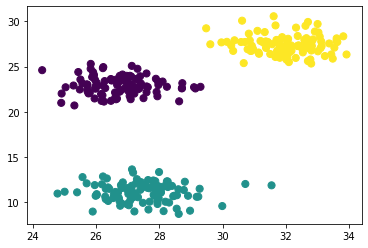

In [29]:
plt.scatter(x[:, 0], x[:, 1], c=y, s=50, cmap='viridis')